In [1]:
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.2MB 100kB/s 
     |████████████████████████████████| 368kB 27.2MB/s 
     |████████████████████████████████| 3.2MB 21.4MB/s 
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
ERROR: ethnicolr 0.2.1 has requirement tensorflow==1.12.3, but you'll have tensorflow 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import os, warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
EPOCHS = 100

In [4]:
def load_data(latent_dimension):
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = x_train / 127.5 - 1.
    x_train = np.expand_dims(x_train, axis = 3)
    y_train = to_categorical(y_train, latent_dimension)
    return x_train, y_train

In [5]:
x_train, y_train = load_data(LATENT_DIMENSION)
x_train.shape, y_train.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (60000, 100))

In [6]:
def build_generator(latent_dimension):
    
    # Noise Input Layers
    noise_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(noise_input_placeholder)
    x = Activation('tanh')(x)
    x = Dense(128 * 7 * 7)(x)
    x = BatchNormalization()(x)
    noise_input = Reshape((7, 7, 128), input_shape = (128 * 7 * 7, ))(x)
    
    # Condition Input Layers
    condition_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(condition_input_placeholder)
    x = Activation('tanh')(x)
    x = Dense(128 * 7 * 7)(x)
    x = BatchNormalization()(x)
    condition_input = Reshape((7, 7, 128), input_shape = (128 * 7 * 7, ))(x)
    
    # Combined Input
    combined_input = Concatenate()([noise_input, condition_input])
    
    # Generator Block 1
    x = UpSampling2D(size = (2, 2))(combined_input)
    x = Conv2D(64, (5, 5), padding = 'same')(x)
    x = Activation('tanh')(x)
    
    # Generator Block 2
    x = UpSampling2D(size = (2, 2))(x)
    x = Conv2D(1, (5, 5), padding = 'same')(x)
    output = Activation('tanh')(x)
    
    generator = Model([noise_input_placeholder, condition_input_placeholder], output, name = 'Generator')
    
    return generator

In [7]:
def build_discriminator(image_shape, latent_dimension):
    
    # Image Input Layers
    image_input_placeholder = Input(image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(image_input_placeholder)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5))(image_input_placeholder)
    x = Activation('tanh')(x)
    image_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    # Condition Input Layers
    condition_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(condition_input_placeholder)
    x = Activation('tanh')(x)
    x = Dense(128 * 12 * 12)(x)
    x = BatchNormalization()(x)
    condition_input = Reshape((12, 12, 128), input_shape = (128 * 12 * 12, ))(x)
    
    combined_input = Concatenate()([image_input, condition_input])
    
    x = Flatten()(combined_input)
    x = Dense(1024)(x)
    x = Activation('tanh')(x)
    output = Dense(1, activation = 'sigmoid')(x)
    
    discriminator = Model([image_input_placeholder, condition_input_placeholder], output, name = 'Discriminator')
    
    return discriminator

In [8]:
def build_gan(generator, discriminator, image_shape, latent_dimension):
    noise_input_placeholder = Input(shape = (latent_dimension, ), name = 'NoiseInput')
    condition_input_placeholder = Input(shape = (latent_dimension, ), name = 'ConditionInput')
    generated_image = generator([noise_input_placeholder, condition_input_placeholder])
    discriminator.trainable = False
    validity = discriminator([generated_image, condition_input_placeholder])
    gan = Model([noise_input_placeholder, condition_input_placeholder], validity)
    return gan

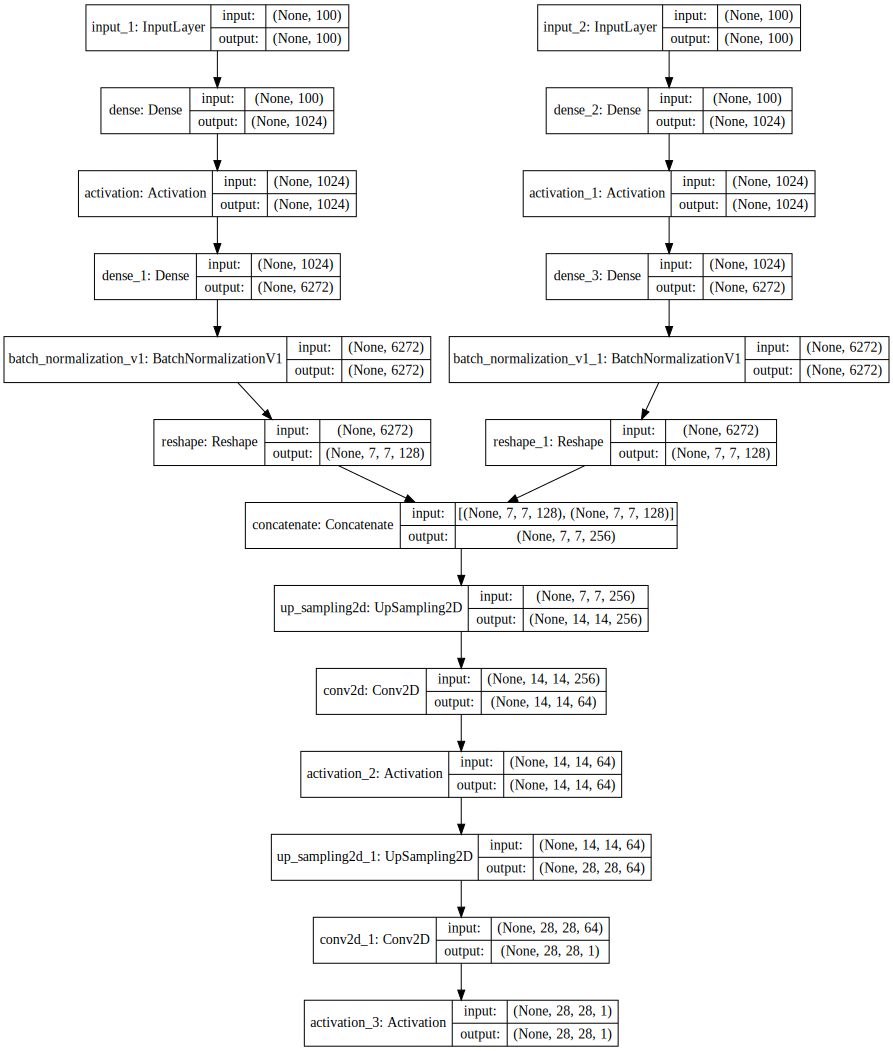

In [9]:
generator = build_generator(100)
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

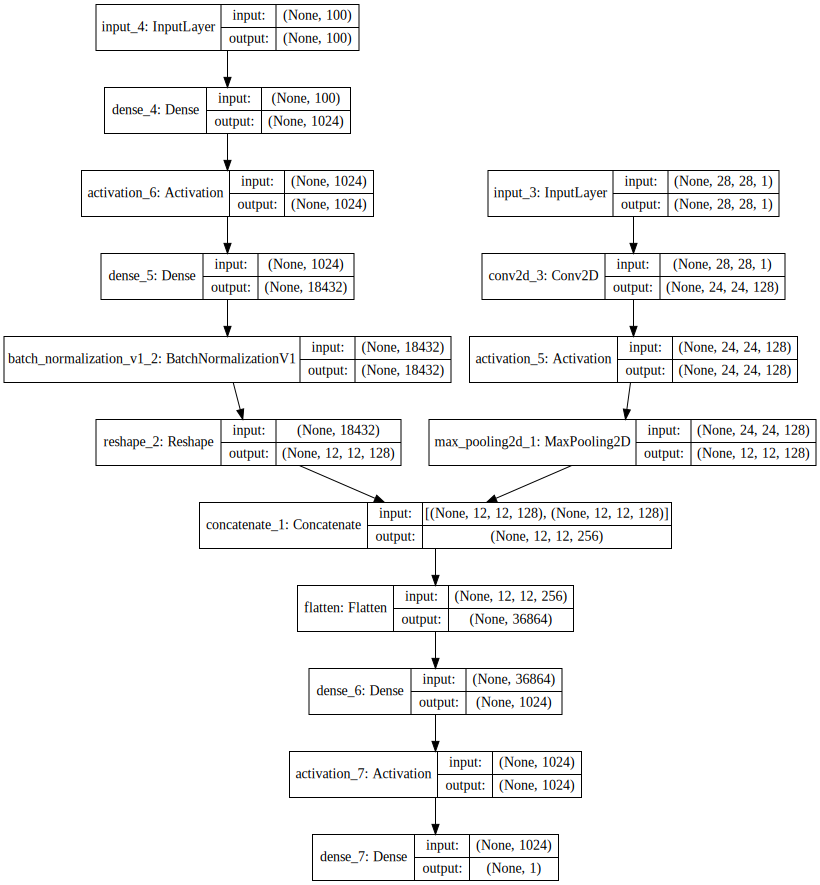

In [10]:
discriminator = build_discriminator((28, 28, 1), 100)
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

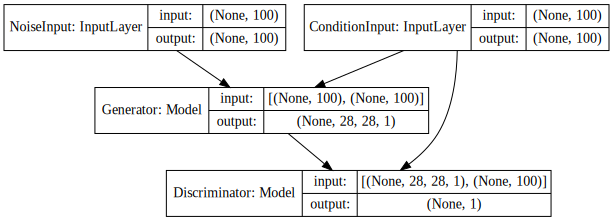

In [11]:
gan = build_gan(generator, discriminator, (28, 28, 1), 100)
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [12]:
optimizer = Adam(0.0002, 0.5)

In [13]:
generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)
discriminator.trainable = True
discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)

In [14]:
for epoch in range(EPOCHS):
    
    progress_bar = tqdm(desc = "Epoch: {0}".format(epoch), total = (x_train.shape[0] // BATCH_SIZE) * BATCH_SIZE)
    
    generator_loss_history, discriminator_loss_history = [], []
    
    for iteration in range(x_train.shape[0] // BATCH_SIZE):
        
        noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))
        
        # Get a Batch from the dataset
        batch_images = x_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        batch_labels = y_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        
        # Fake Images
        generated_images = generator.predict([noise, batch_labels])
        
        # Batch Dataset
        x = np.concatenate((batch_images, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        discriminator_conditions = np.concatenate((batch_labels, batch_labels))
        
        # Training the Discriminator
        discriminator_loss = discriminator.train_on_batch([x, discriminator_conditions], y)
        discriminator_loss_history.append(discriminator_loss)
        
        noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))
        
        # Training the Generator
        discriminator.trainable = False
        generator_loss = gan.train_on_batch([noise, batch_labels], [1] * BATCH_SIZE)
        generator_loss_history.append(generator_loss)
        discriminator.trainable = True
        
        progress_bar.update(BATCH_SIZE)

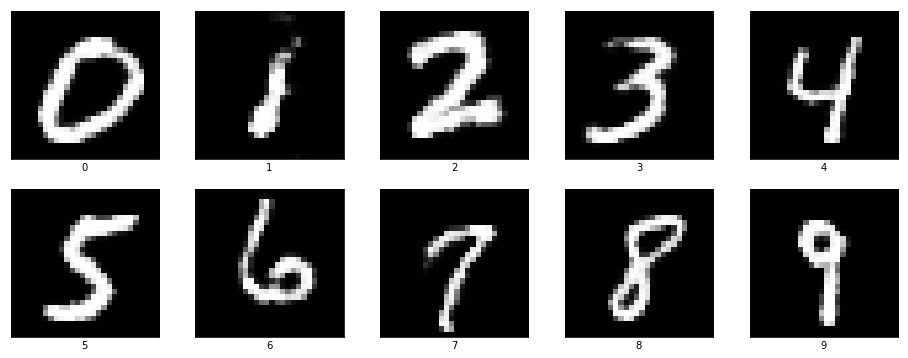

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (16, 6))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    noise = np.random.uniform(0, 1, size = (1, LATENT_DIMENSION))
    condition = to_categorical(np.array([i]), LATENT_DIMENSION)
    generated_image = generator.predict([noise, condition]).reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
    ax.imshow(generated_image, cmap = 'gray')
    ax.set_xlabel(str(i))
plt.show()

In [16]:
generator.save('./generator.h5')